#### <center>Création du modèle pour la détection d'émotions dans du texte avec Scikit-Learn</center>

##### 1. Importation des module

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import neattext.functions as nfx
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, plot_confusion_matrix

In [3]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

In [4]:
warnings.filterwarnings("ignore")

##### 2. Chargement du jeu de données

In [5]:
df = pd.read_csv("datasets/emotion_dataset.csv")

##### 3. Exploration des données

In [6]:
df.head()

,Emotion,Text
0,neutral,Why ?
1,joy,Sage Act upgrade on my to do list for tommorow.
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3,joy,Such an eye ! The true hazel eye-and so brill...
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...


Nous voyons donc que le jeu de données est composé de deux colonnes une colonne Text qui contient les messages et une colonne Emotion qui décrit l'émotion contenu dans ce message.

In [7]:
df.shape

(34792, 2)

In [8]:
df.isnull().sum()

Emotion    0
Text       0
dtype: int64

Nous avons donc 34792 exemple et il n'y a pas de données manquantes

In [9]:
df["Emotion"].unique()

array(['neutral', 'joy', 'sadness', 'fear', 'surprise', 'anger', 'shame',
       'disgust'], dtype=object)

In [10]:
df["Emotion"].value_counts()

joy         11045
sadness      6722
fear         5410
anger        4297
surprise     4062
neutral      2254
disgust       856
shame         146
Name: Emotion, dtype: int64

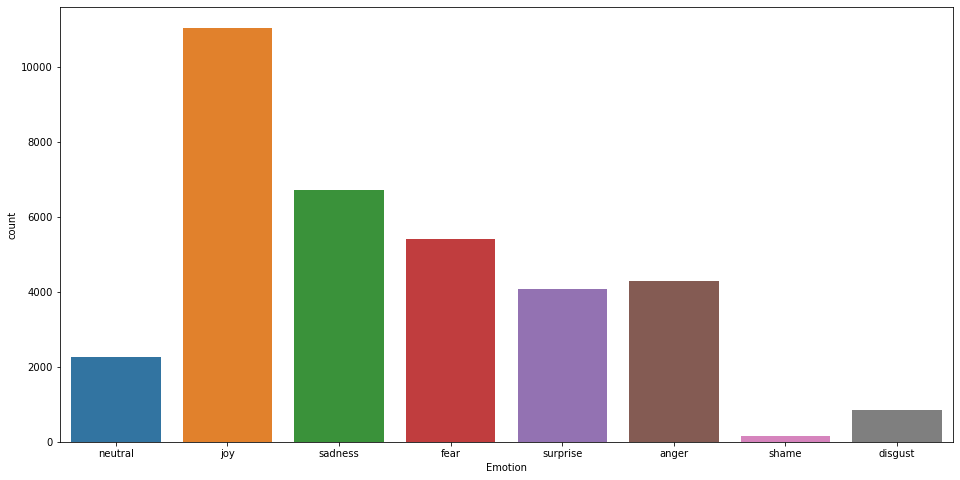

In [11]:
plt.figure(figsize=(16,8))
sns.countplot(x="Emotion", data=df)
plt.show()

Nous pouvons donc voir que la joie est l'émotion la plus présente dans le jeu de données et que shame et disgut sont très peu représenté donc notre jeu de donnée n'est pas équilibré.
On pourra donc supprimer les shame et disgut pour ne pas biaiser le modèle

In [12]:
df.drop(df[df['Emotion'].isin(["neutral","shame","disgust"])==True].index, inplace=True)

In [13]:
df.shape

(31536, 2)

##### 4. Analyse des sentiments

In [14]:
def getSentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        res = "Positif"
    elif sentiment < 0:
        res = "Negatif"
    else:
        res = "Neutre"
    return res

In [15]:
df["Sentiment"] = df["Text"].apply(getSentiment)

In [16]:
df.head()

,Emotion,Text,Sentiment
1,joy,Sage Act upgrade on my to do list for tommorow.,Neutre
2,sadness,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,Negatif
3,joy,Such an eye ! The true hazel eye-and so brill...,Positif
4,joy,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,Neutre
5,fear,I'm expecting an extremely important phonecall...,Positif


<Figure size 1440x1152 with 0 Axes>

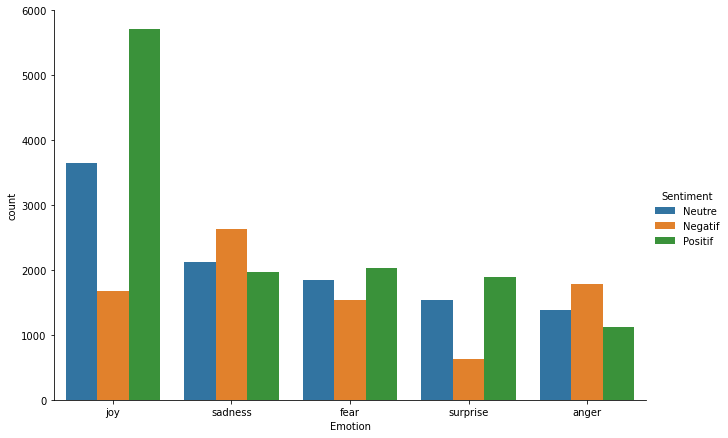

In [17]:
plt.figure(figsize=(20,16))
sns.factorplot(x="Emotion",hue="Sentiment", kind="count", data=df, size=6, aspect=1.5)
plt.show()

En analysant ce graphique on peut donc voir que les émotions qui sont généralement considérés postives comme la joie par exemple sont considérés positives sont en majorité vue comme celà dans côté sentiment.
De même pour anger et sadness.

##### Nettoyage des données
Dans cette étape nous allons enlevés le bruit dans les données de la colonne Text:
- caractères spéciaux
- ponctuations
- emojis
Pour celà nous allons utiliser neattext qui est une bibliothèque qui permet de nettoyer des données textuelles

In [18]:
df["Text"]

1          Sage Act upgrade on my to do list for tommorow.
2        ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...
3         Such an eye ! The true hazel eye-and so brill...
4        @Iluvmiasantos ugh babe.. hugggzzz for u .!  b...
5        I'm expecting an extremely important phonecall...
                               ...                        
34787    @MichelGW have you gift! Hope you like it! It'...
34788    The world didnt give it to me..so the world MO...
34789                             A man robbed me today . 
34790    Youu call it JEALOUSY, I call it of #Losing YO...
34791    I think about you baby, and I dream about you ...
Name: Text, Length: 31536, dtype: object

In [19]:
df['Cleaned_Text'] = df["Text"].apply(nfx.remove_stopwords).apply(nfx.remove_userhandles).apply(nfx.remove_punctuations)

In [20]:
df[["Text","Cleaned_Text"]]

,Text,Cleaned_Text
1,Sage Act upgrade on my to do list for tommorow.,Sage Act upgrade list tommorow
2,ON THE WAY TO MY HOMEGIRL BABY FUNERAL!!! MAN ...,WAY HOMEGIRL BABY FUNERAL MAN HATE FUNERALS SH...
3,Such an eye ! The true hazel eye-and so brill...,eye true hazel eyeand brilliant Regular feat...
4,@Iluvmiasantos ugh babe.. hugggzzz for u .! b...,ugh babe hugggzzz u babe naamazed nga ako e...
5,I'm expecting an extremely important phonecall...,Im expecting extremely important phonecall min...
...,...,...
34787,@MichelGW have you gift! Hope you like it! It'...,gift Hope like it hand wear Itll warm Lol
34788,The world didnt give it to me..so the world MO...,world didnt meso world DEFINITELY cnt away
34789,A man robbed me today .,man robbed today
34790,"Youu call it JEALOUSY, I call it of #Losing YO...",Youu JEALOUSY #Losing YOU


##### Extraction de mots clés
Nous allons tenter d'obtenir les mots clés qui apparaissent le plus souvent dans chaque classe d'émotions

In [21]:
def get_mots_cles(text, num=50):
    mots = [mot for mot in text]
    mots_frequent = Counter(token).most_common(num)
    return dic(mots_frequent)

In [22]:
def nuage_mot_emotion(doc, emotion):
    nuage = WordCloud().generate(doc)
    plt.figure(figsize=(12,8))
    plt.imshow(nuage, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuage pour {emotion}", fontsize="30")
    plt.show()

In [23]:
liste_emotions = df["Emotion"].unique().tolist()

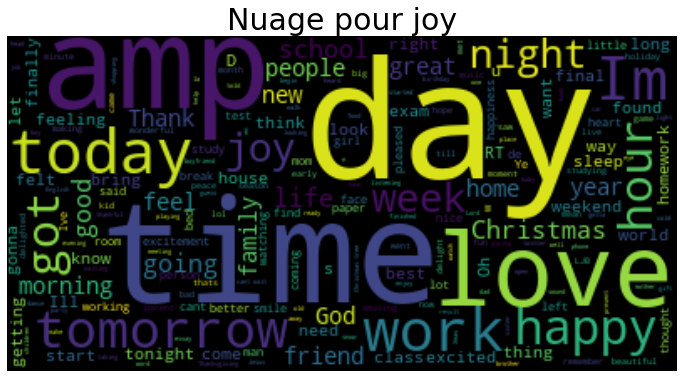

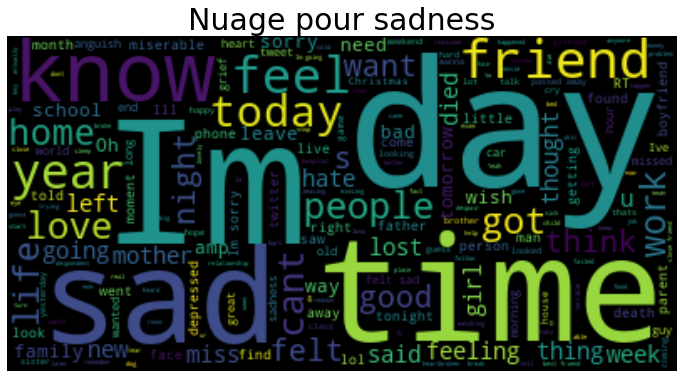

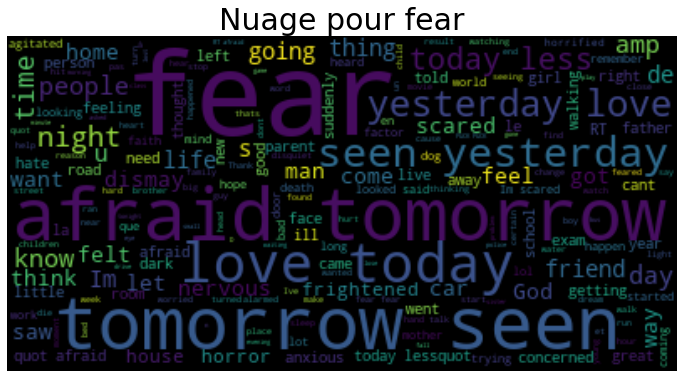

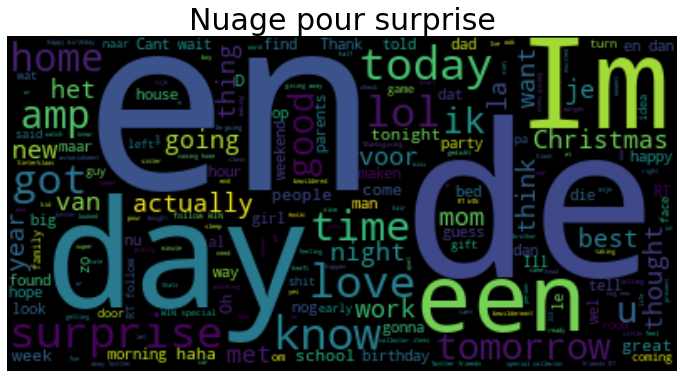

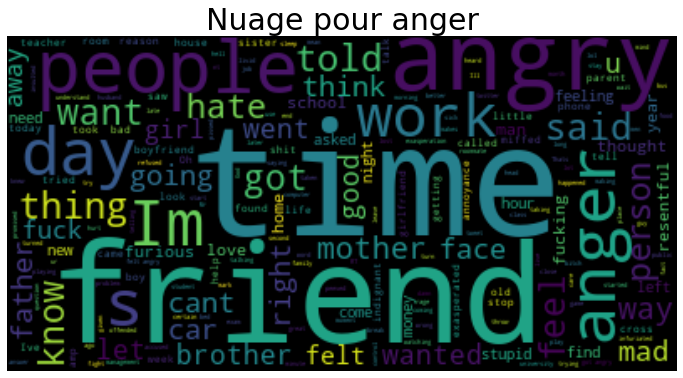

In [24]:
for emotion in liste_emotions:
    nuage_mot_emotion(" ".join(df[df["Emotion"]==emotion]["Cleaned_Text"].tolist()), emotion)

##### 6. Choix du modèle

In [25]:
features = df["Cleaned_Text"]
labels = df["Emotion"]

In [26]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=43)

In [27]:
def tokenize(data):    
    data = word_tokenize(data)
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
    return stem_data

In [28]:
vect = CountVectorizer(tokenizer=tokenize, ngram_range=(1, 2))

In [29]:
#1 Model - Logistic Regression
m1 = make_pipeline(vect, LogisticRegression(multi_class="auto"))
m1.fit(x_train, y_train)
pred1 = m1.predict(x_test)
print(classification_report(y_test, pred1))
print("Score: {}".format(accuracy_score(y_test,pred1)))

              precision    recall  f1-score   support

       anger       0.70      0.56      0.62      1317
        fear       0.78      0.68      0.73      1596
         joy       0.65      0.83      0.73      3317
     sadness       0.66      0.63      0.64      2025
    surprise       0.63      0.42      0.51      1206

    accuracy                           0.67      9461
   macro avg       0.68      0.63      0.65      9461
weighted avg       0.68      0.67      0.67      9461

Score: 0.6733960469295001


In [30]:
# 2 model - MutltinomialNB
m2 = make_pipeline(vect, MultinomialNB())
m2.fit(x_train, y_train)
pred2 = m2.predict(x_test)
print(classification_report(y_test, pred2))
print("Score: {}".format(accuracy_score(y_test,pred2)))

              precision    recall  f1-score   support

       anger       0.87      0.42      0.57      1317
        fear       0.82      0.61      0.70      1596
         joy       0.54      0.92      0.68      3317
     sadness       0.69      0.54      0.61      2025
    surprise       0.74      0.23      0.35      1206

    accuracy                           0.63      9461
   macro avg       0.73      0.55      0.58      9461
weighted avg       0.69      0.63      0.61      9461

Score: 0.6308001268364867


In [31]:
# 3 Model - GradientBoostingClassifier
m3 = make_pipeline(vect, GradientBoostingClassifier())
m3.fit(x_train, y_train) 
pred3 = m3.predict(x_test)
print(classification_report(y_test, pred3))
print("Score: {}".format(m3.score(y_test,pred3)))

              precision    recall  f1-score   support

       anger       0.82      0.37      0.51      1317
        fear       0.89      0.45      0.60      1596
         joy       0.47      0.94      0.63      3317
     sadness       0.84      0.38      0.53      2025
    surprise       0.71      0.27      0.39      1206

    accuracy                           0.58      9461
   macro avg       0.75      0.48      0.53      9461
weighted avg       0.70      0.58      0.55      9461

Score: 0.5753091639361589


In [32]:
# 4 Model - LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
m3 = make_pipeline(vect, LinearSVC())
m3.fit(x_train, y_train) 
pred3 = m3.predict(x_test)
print(classification_report(y_test, pred3))
print("Score: {}".format(m3.score(y_test,pred3)))

              precision    recall  f1-score   support

       anger       0.65      0.59      0.62      1317
        fear       0.78      0.69      0.73      1596
         joy       0.66      0.80      0.72      3317
     sadness       0.64      0.62      0.63      2025
    surprise       0.60      0.44      0.51      1206

    accuracy                           0.67      9461
   macro avg       0.67      0.63      0.64      9461
weighted avg       0.67      0.67      0.66      9461

Score: 0.6673713138146073


##### Optimisation des hyperparamètres et cross validation

In [33]:
parameters = [{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              {'penalty':['none', 'elasticnet', 'l1', 'l2']},
              {'C':[0.001, 0.01, 0.1, 1, 10, 100]}]
x_train1 = CountVectorizer().fit_transform(x_train)
clf = GridSearchCV(LogisticRegression(),param_grid = parameters, scoring = 'accuracy',cv = 5,verbose=0)
clf.fit(x_train1, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']},
                         {'penalty': ['none', 'elasticnet', 'l1', 'l2']},
                         {'C': [0.001, 0.01, 0.1, 1, 10, 100]}],
             scoring='accuracy')

In [34]:
clf.best_estimator_

LogisticRegression(solver='liblinear')

In [35]:
model = make_pipeline(vect,LogisticRegression(solver="liblinear",multi_class="auto",max_iter=200))
model.fit(x_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function tokenize at 0x000001CC61FBE550>)),
                ('logisticregression',
                 LogisticRegression(max_iter=200, solver='liblinear'))])

##### Evaluation du modèle

In [36]:
predictions = model.predict(x_test)

In [37]:
classification_report(y_test, predictions)
print("Score {}".format(accuracy_score(y_test, predictions)))

Score 0.6742416235070289


In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

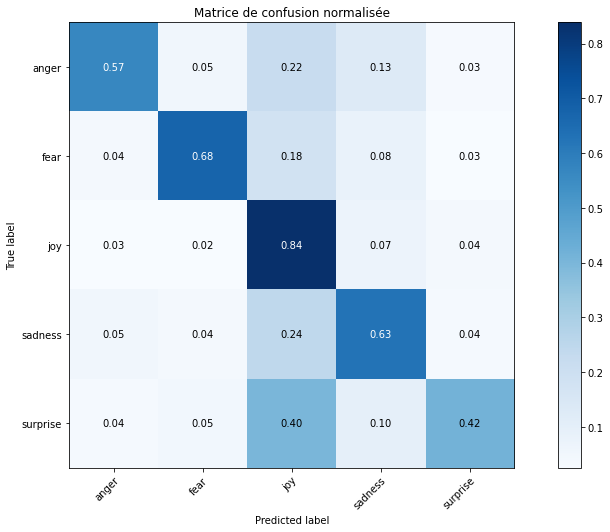

In [39]:
plot_confusion_matrix(y_test, predictions, classes=model.classes_, normalize=True, title='Matrice de confusion normalisée')
plt.show()

##### Sauvegarde du modèle

In [40]:
import pickle
pipe_lr = model
pipeline_file = open("emotion_classifier_pipe_lr.pkl","wb")
pickle.dump(pipe_lr,pipeline_file)
pipeline_file.close()